In [1]:
!ls input

sample_submission.csv     test.json                 train.json
sample_submission.csv.zip test.json.zip             train.json.zip


In [65]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from nltk import bigrams
from sklearn.feature_extraction.text import TfidfTransformer


% matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [3]:
train = pd.read_json("input/train.json")
test = pd.read_json("input/test.json")

In [4]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
type(train.ingredients.iloc[0])

list

In [7]:
train['_test'] = False
test['_test'] = True
data = pd.concat([train, test])

In [42]:
def tokenize(ingredients):
    _ing = []
    for ing in ingredients:
        _split = ing.split(" ")
        if(len(_split) == 1):
            _ing.append(ing)
        if len(_split) == 2:
            _ing.append(ing)
            _ing.append(_split[0])
            _ing.append(_split[1])
            
        if len(_split) >= 3:
            for b in bigrams(_split):
                _ing.append(" ".join(b))
            _ing.append(ing)
    return _ing

In [43]:
data['ingredients_tok'] = data['ingredients'].apply(tokenize)

In [8]:
# bag of words approach

In [48]:
data_list = pd.concat([
        pd.DataFrame({
                'ingredient': line['ingredients_tok'],
                'id': line['id'],
                'cuisine': line['cuisine'],
                '_test': line['_test']}
        )
        for _,line in data.iterrows()
    ])

In [46]:
data_list.head()

,_test,cuisine,id,ingredients_tok
0,False,greek,10259,romaine lettuce
1,False,greek,10259,romaine
2,False,greek,10259,lettuce
3,False,greek,10259,black olives
4,False,greek,10259,black


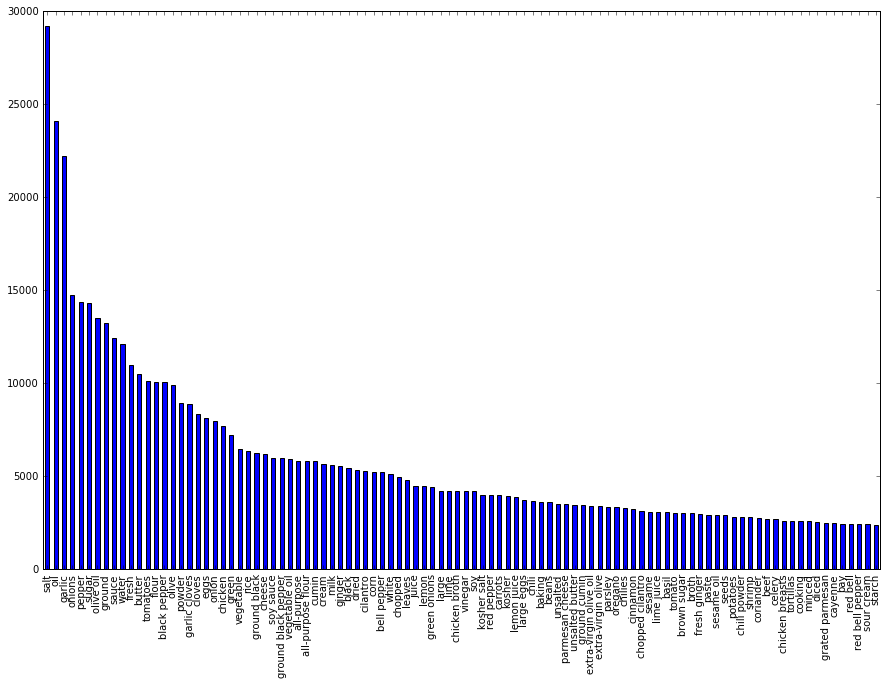

In [49]:
data_list['ingredient'].value_counts().sort_values(ascending=False).head(100).plot(kind='bar')

In [51]:
ingredientEncoder = LabelEncoder()
data_list['ingredient_enc'] = ingredientEncoder.fit_transform(data_list.ingredient)

cuisineEncoder = LabelEncoder()
data_list['cuisine_enc'] = cuisineEncoder.fit_transform(data_list.cuisine)

In [52]:
data_list.head()

,_test,cuisine,id,ingredient,ingredient_enc,cuisine_enc
0,False,greek,10259,romaine lettuce,9644,7
1,False,greek,10259,romaine,9643,7
2,False,greek,10259,lettuce,7071,7
3,False,greek,10259,black olives,2447,7
4,False,greek,10259,black,2413,7


In [62]:
ones = np.ones(len(data_list))
sparse_matrix = sparse.csr_matrix(
    (ones, (data_list.id, data_list.ingredient_enc)))

In [63]:
train_row = train['id']
train_sp = sparse_matrix[train_row, :]
train_labels = data[~data['_test']]['cuisine']

test_row = test['id']
test_sp = sparse_matrix[test_row, :]

In [69]:
clf = LinearSVC()
scores = cross_validation.cross_val_score(clf, train_sp, train_labels, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.01)


In [70]:
# make a prediction
clf = LinearSVC()
clf.fit(train_sp, train_labels)
predict = clf.predict(test_sp)
test['cuisine'] = predict

In [71]:
test.head()

,id,ingredients,_test,cuisine
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",True,irish
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",True,southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",True,italian
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",True,cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...",True,italian


In [72]:
test[['id', 'cuisine']].to_csv('output/submission.csv', index=False)